# Scheduling Optimization - Enhanced Simulation with Visualization

This notebook demonstrates request scheduling optimization through a realistic simulation.
It compares **FCFS (First-Come-First-Served)** vs **Prefix-Aware Scheduling**.

**Key Concepts:**
- **FCFS**: Processes each request independently (no cache sharing)
- **Prefix-Aware**: Identifies common prefixes and shares computation across requests

**Real-world Application:** Production systems like vLLM use similar prefix-aware batching for efficient inference.

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

SIMULATED_KV_CACHE = {}

def process_token_by_token(prompt: str, verbose: bool = True):
    """Process a prompt token by token, tracking cache hits/misses."""
    global SIMULATED_KV_CACHE
    total_cost = 0
    cache_hits = 0
    cache_misses = 0
    
    if verbose:
        print(f"\nProcessing prompt: '{prompt[:60]}...'")
    
    prompt_tokens = prompt.split()
    for i in range(len(prompt_tokens)):
        prefix = " ".join(prompt_tokens[:i+1])
        
        if prefix in SIMULATED_KV_CACHE:
            if verbose:
                print(f"  -> ✅ CACHE HIT on prefix (length {len(prefix)} chars)")
            cache_hits += 1
        else:
            cost = len(prefix)
            SIMULATED_KV_CACHE[prefix] = cost
            total_cost += cost
            cache_misses += 1
            if verbose:
                print(f"  -> ❌ CACHE MISS - Computing (Cost: {cost})")
            # Simulate computation time
            time.sleep(0.005)
    
    if verbose:
        print(f"  => Finished. Cost: {total_cost}, Hits: {cache_hits}, Misses: {cache_misses}")
    
    return total_cost, cache_hits, cache_misses

def fcfs_scheduler(requests: list, verbose: bool = True):
    """Simulates a naive FCFS scheduler where each request is processed in isolation."""
    if verbose:
        print("\n" + "="*60)
        print("🐌 RUNNING NAIVE FCFS SCHEDULER (ISOLATED RUNS)")
        print("="*60)
    
    global SIMULATED_KV_CACHE
    total_computation_cost = 0
    request_costs = []
    request_times = []
    total_hits = 0
    total_misses = 0
    
    for i, req in enumerate(requests):
        # Clear cache for each request (no sharing)
        SIMULATED_KV_CACHE.clear()
        
        if verbose:
            print(f"\n--- Processing Request {i+1} with FRESH cache ---")
        
        start_time = time.perf_counter()
        cost, hits, misses = process_token_by_token(req['prompt'], verbose=verbose)
        elapsed = time.perf_counter() - start_time
        
        total_computation_cost += cost
        request_costs.append(cost)
        request_times.append(elapsed)
        total_hits += hits
        total_misses += misses
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"FCFS COMPLETE")
        print(f"Total Cost: {total_computation_cost}")
        print(f"Total Cache Hits: {total_hits}, Misses: {total_misses}")
        print(f"Total Time: {sum(request_times):.3f}s")
    
    return {
        'total_cost': total_computation_cost,
        'request_costs': request_costs,
        'request_times': request_times,
        'total_hits': total_hits,
        'total_misses': total_misses,
        'total_time': sum(request_times)
    }

def prefix_aware_scheduler(requests: list, verbose: bool = True):
    """Simulates a smart prefix-aware scheduler that shares cache across requests."""
    if verbose:
        print("\n" + "="*60)
        print("🚀 RUNNING PREFIX-AWARE SCHEDULER")
        print("="*60)
    
    global SIMULATED_KV_CACHE
    SIMULATED_KV_CACHE.clear()
    
    total_computation_cost = 0
    request_costs = []
    request_times = []
    total_hits = 0
    total_misses = 0
    
    prompts = [req['prompt'] for req in requests]
    common_prefix = os.path.commonprefix(prompts)
    
    # Pre-fill the cache with common prefix ONCE
    if common_prefix and verbose:
        print(f"\n--- Pre-filling SHARED cache with common prefix ---")
        print(f"Common prefix length: {len(common_prefix)} characters")
    
    # Process all requests with shared cache
    for i, req in enumerate(requests):
        if verbose:
            print(f"\n--- Processing Request {i+1} with SHARED cache ---")
        
        start_time = time.perf_counter()
        cost, hits, misses = process_token_by_token(req['prompt'], verbose=verbose)
        elapsed = time.perf_counter() - start_time
        
        total_computation_cost += cost
        request_costs.append(cost)
        request_times.append(elapsed)
        total_hits += hits
        total_misses += misses
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"PREFIX-AWARE COMPLETE")
        print(f"Total Cost: {total_computation_cost}")
        print(f"Total Cache Hits: {total_hits}, Misses: {total_misses}")
        print(f"Total Time: {sum(request_times):.3f}s")
    
    return {
        'total_cost': total_computation_cost,
        'request_costs': request_costs,
        'request_times': request_times,
        'total_hits': total_hits,
        'total_misses': total_misses,
        'total_time': sum(request_times)
    }

# --- MAIN EXECUTION ---
shared_context = "User: I'd like to book a flight to Paris. AI: Of course! For which dates? User: From October 25th to November 5th. AI: Great. I have a flight on Air France for $800."

REQUESTS = [
    {'id': 1, 'prompt': f"{shared_context} User: What is the baggage allowance?"},
    {'id': 2, 'prompt': f"{shared_context} User: Is that a direct flight?"},
    {'id': 3, 'prompt': f"{shared_context} User: Can you check for a cheaper flight on a different airline?"},
]

print("Starting scheduling comparison...")
print(f"Number of requests: {len(REQUESTS)}")
print(f"Shared context length: {len(shared_context)} characters")

# Run both schedulers
fcfs_results = fcfs_scheduler(REQUESTS, verbose=True)
prefix_aware_results = prefix_aware_scheduler(REQUESTS, verbose=True)

Starting scheduling comparison...
Number of requests: 3
Shared context length: 165 characters

🐌 RUNNING NAIVE FCFS SCHEDULER (ISOLATED RUNS)

--- Processing Request 1 with FRESH cache ---

Processing prompt: 'User: I'd like to book a flight to Paris. AI: Of course! For...'
  -> ❌ CACHE MISS - Computing (Cost: 5)
  -> ❌ CACHE MISS - Computing (Cost: 9)
  -> ❌ CACHE MISS - Computing (Cost: 14)
  -> ❌ CACHE MISS - Computing (Cost: 17)
  -> ❌ CACHE MISS - Computing (Cost: 22)
  -> ❌ CACHE MISS - Computing (Cost: 24)
  -> ❌ CACHE MISS - Computing (Cost: 31)
  -> ❌ CACHE MISS - Computing (Cost: 34)
  -> ❌ CACHE MISS - Computing (Cost: 41)
  -> ❌ CACHE MISS - Computing (Cost: 45)
  -> ❌ CACHE MISS - Computing (Cost: 48)
  -> ❌ CACHE MISS - Computing (Cost: 56)
  -> ❌ CACHE MISS - Computing (Cost: 60)
  -> ❌ CACHE MISS - Computing (Cost: 66)
  -> ❌ CACHE MISS - Computing (Cost: 73)
  -> ❌ CACHE MISS - Computing (Cost: 79)
  -> ❌ CACHE MISS - Computing (Cost: 84)
  -> ❌ CACHE MISS - Computing 

In [3]:
# --- Display Results Summary ---
print("\n" + "="*60)
print("📊 RESULTS SUMMARY")
print("="*60)

print("\nFCFS (First-Come-First-Served):")
print(f"  Total Computation Cost: {fcfs_results['total_cost']}")
print(f"  Total Time: {fcfs_results['total_time']:.3f}s")
print(f"  Cache Hits: {fcfs_results['total_hits']}")
print(f"  Cache Misses: {fcfs_results['total_misses']}")
print(f"  Cache Hit Rate: {fcfs_results['total_hits'] / (fcfs_results['total_hits'] + fcfs_results['total_misses']) * 100:.1f}%")

print("\nPrefix-Aware Scheduling:")
print(f"  Total Computation Cost: {prefix_aware_results['total_cost']}")
print(f"  Total Time: {prefix_aware_results['total_time']:.3f}s")
print(f"  Cache Hits: {prefix_aware_results['total_hits']}")
print(f"  Cache Misses: {prefix_aware_results['total_misses']}")
print(f"  Cache Hit Rate: {prefix_aware_results['total_hits'] / (prefix_aware_results['total_hits'] + prefix_aware_results['total_misses']) * 100:.1f}%")

# Calculate improvements
cost_reduction = (1 - prefix_aware_results['total_cost'] / fcfs_results['total_cost']) * 100
time_reduction = (1 - prefix_aware_results['total_time'] / fcfs_results['total_time']) * 100
speedup = fcfs_results['total_time'] / prefix_aware_results['total_time']

print("\n" + "="*60)
print("⚡ PERFORMANCE IMPROVEMENT")
print("="*60)
print(f"Computation Cost Reduction: {cost_reduction:.1f}%")
print(f"Time Reduction: {time_reduction:.1f}%")
print(f"Speedup: {speedup:.2f}x faster")
print(f"Cache Efficiency Gain: {prefix_aware_results['total_hits'] - fcfs_results['total_hits']} additional hits")


📊 RESULTS SUMMARY

FCFS (First-Come-First-Served):
  Total Computation Cost: 12861
  Total Time: 0.641s
  Cache Hits: 0
  Cache Misses: 123
  Cache Hit Rate: 0.0%

Prefix-Aware Scheduling:
  Total Computation Cost: 6983
  Total Time: 0.287s
  Cache Hits: 68
  Cache Misses: 55
  Cache Hit Rate: 55.3%

⚡ PERFORMANCE IMPROVEMENT
Computation Cost Reduction: 45.7%
Time Reduction: 55.2%
Speedup: 2.23x faster
Cache Efficiency Gain: 68 additional hits



📊 Comprehensive graph saved as 'scheduling_comparison.png'


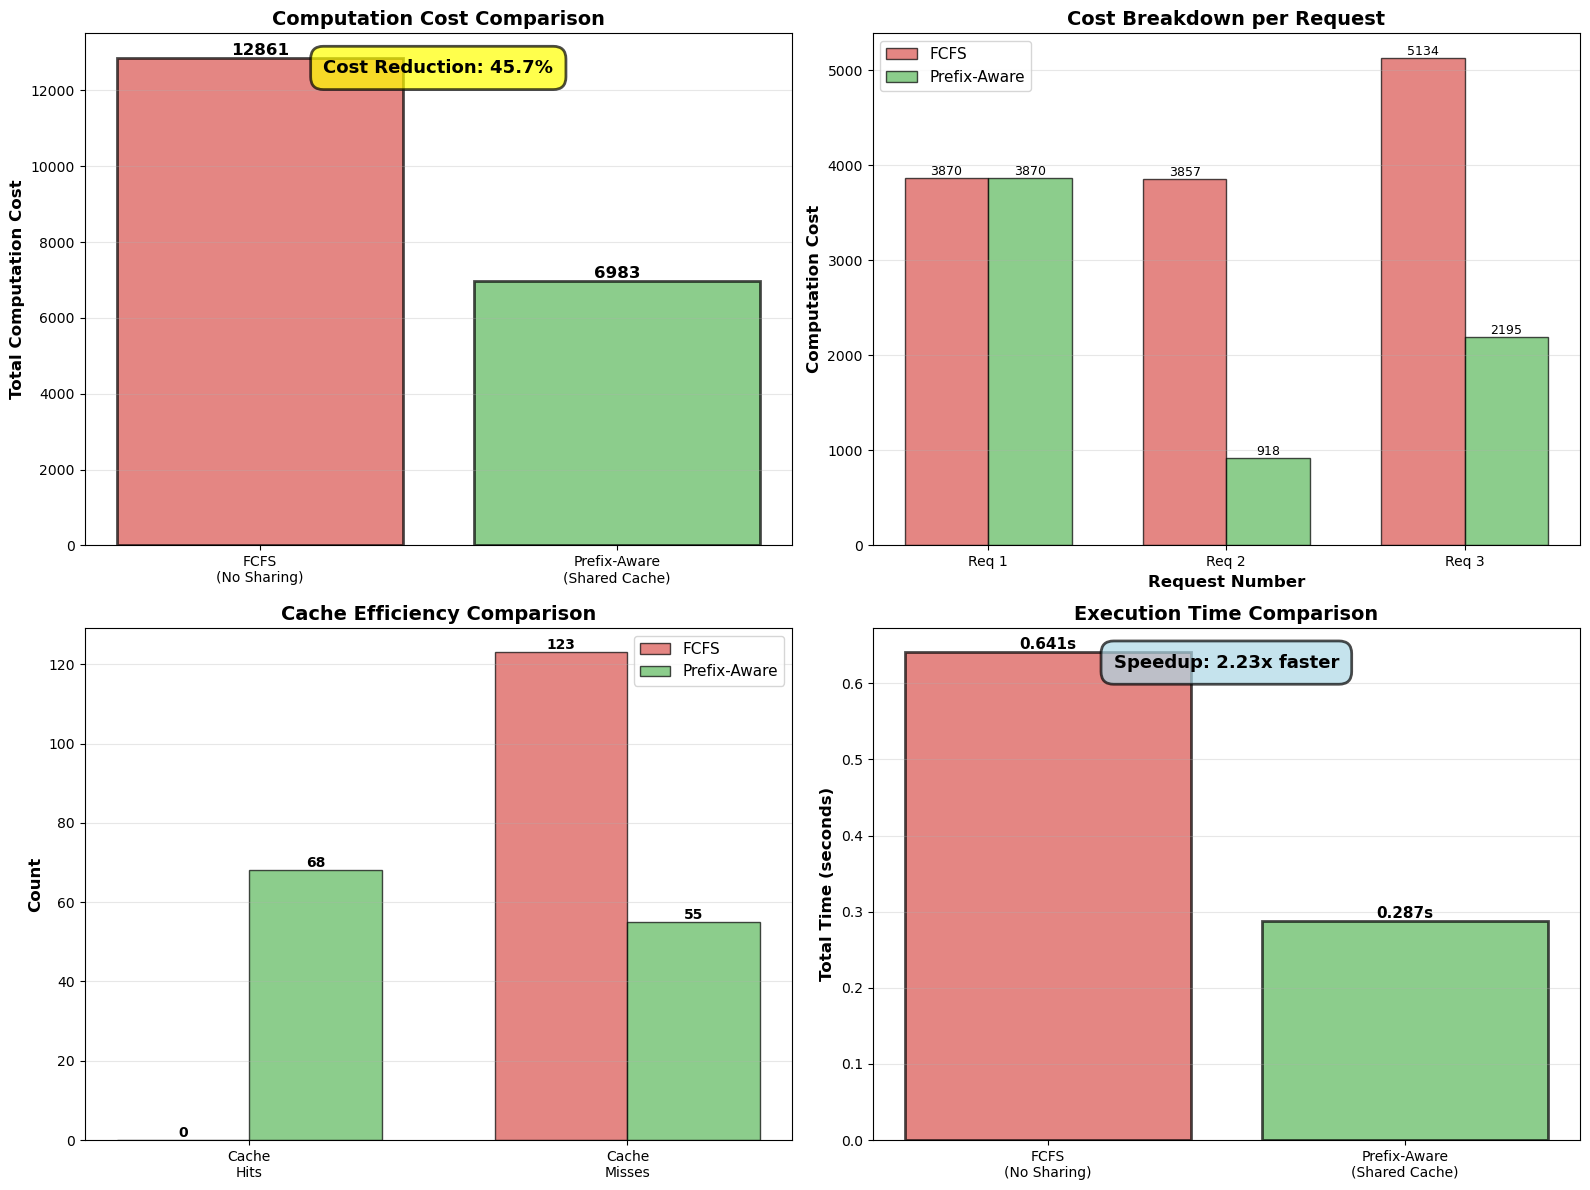


✅ Scheduling Optimization Experiment Complete!


In [4]:
# --- Create Comprehensive Visualizations ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total Computation Cost Comparison
schedulers = ['FCFS\n(No Sharing)', 'Prefix-Aware\n(Shared Cache)']
costs = [fcfs_results['total_cost'], prefix_aware_results['total_cost']]
colors = ['#d9534f', '#5cb85c']

bars1 = ax1.bar(schedulers, costs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Computation Cost', fontsize=12, fontweight='bold')
ax1.set_title('Computation Cost Comparison', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add savings annotation
ax1.text(0.5, 0.95, f'Cost Reduction: {cost_reduction:.1f}%', 
         transform=ax1.transAxes, ha='center', va='top',
         fontsize=13, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', alpha=0.7, edgecolor='black', linewidth=2))

# Plot 2: Per-Request Cost Breakdown
x = np.arange(len(REQUESTS))
width = 0.35

bars2_1 = ax2.bar(x - width/2, fcfs_results['request_costs'], width, 
                  label='FCFS', color='#d9534f', alpha=0.7, edgecolor='black')
bars2_2 = ax2.bar(x + width/2, prefix_aware_results['request_costs'], width,
                  label='Prefix-Aware', color='#5cb85c', alpha=0.7, edgecolor='black')

ax2.set_ylabel('Computation Cost', fontsize=12, fontweight='bold')
ax2.set_xlabel('Request Number', fontsize=12, fontweight='bold')
ax2.set_title('Cost Breakdown per Request', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Req {i+1}' for i in range(len(REQUESTS))])
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars2_1, bars2_2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Plot 3: Cache Hit/Miss Comparison
categories = ['Cache\nHits', 'Cache\nMisses']
fcfs_cache = [fcfs_results['total_hits'], fcfs_results['total_misses']]
prefix_cache = [prefix_aware_results['total_hits'], prefix_aware_results['total_misses']]

x_pos = np.arange(len(categories))
width = 0.35

bars3_1 = ax3.bar(x_pos - width/2, fcfs_cache, width, 
                  label='FCFS', color='#d9534f', alpha=0.7, edgecolor='black')
bars3_2 = ax3.bar(x_pos + width/2, prefix_cache, width,
                  label='Prefix-Aware', color='#5cb85c', alpha=0.7, edgecolor='black')

ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
ax3.set_title('Cache Efficiency Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(categories)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars3_1, bars3_2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Time Comparison with Speedup
times = [fcfs_results['total_time'], prefix_aware_results['total_time']]
bars4 = ax4.bar(schedulers, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Total Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add speedup annotation
ax4.text(0.5, 0.95, f'Speedup: {speedup:.2f}x faster', 
         transform=ax4.transAxes, ha='center', va='top',
         fontsize=13, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightblue', alpha=0.7, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.savefig("scheduling_comparison.png", dpi=150, bbox_inches='tight')
print("\n📊 Comprehensive graph saved as 'scheduling_comparison.png'")
plt.show()

print("\n" + "="*60)
print("✅ Scheduling Optimization Experiment Complete!")
print("="*60)